# DCIP Complex geology

Using PGI regularization with Gaussian mixture random markov field model and SAM segmentation lets try more complex geology

In [21]:
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)


class SamClassificationModel():

    def __init__(
        self,
        mesh,
        kneighbors: int=20,
        segmentation_model_checkpoint: str=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
    ):
        
        self.segmentation_model_checkpoint = segmentation_model_checkpoint
        self.mesh = mesh
        self.kneighbors = kneighbors
        self.indexpoint = np.zeros((mesh.nC, kneighbors + 1))

        # load segmentation network model
        sam = sam_model_registry["vit_h"](checkpoint=self.segmentation_model_checkpoint)
        self.mask_generator = SamAutomaticMaskGenerator(sam)

    def fit(self, model:np.ndarray=None, ) -> dict:

        if model is None:

            raise ValueError('need a model')
        
        else:

            model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

            image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
            image_rgb = image_rgb.convert('RGB')

            result = self.mask_generator.generate(np.asarray(image_rgb))


            # ---------------------------------------------------------------------------------------------

            # create a matrix that holds information about overlapping mask if they happen to

            # this is done using intersection over union method

            #

            nlayers = len(result)

            union_matrix = np.zeros((nlayers, nlayers))
            for ii in range(nlayers):
                for jj in range(nlayers):
                    iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
                    union_matrix[ii, jj] = iou_score
                    print("IoU score:", iou_score)

            # ------------------------------------------------------------------------------------

            # modify the overlap matrix to assign the proper neighbors mask in the case of onions

            #

            sub_union_matrix = union_matrix[1:, 1:].copy()

            # calculate how many non zero in a row of our overlap matrix
            for jj in range(sub_union_matrix.shape[0]):

                if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                    mask_index = np.nonzero(sub_union_matrix[jj, :])
                    print(mask_index[0][-1])
                    # check which mask is larger
                    sub_union_matrix[jj, mask_index[0][-1]] = 1
                    sub_union_matrix[jj, mask_index[0][0]] = 0

            # --------------------------------------------------------------------------------------

            # assign each cell a mask to assign it's neighbors

            #

            hx, hy = self.mesh.shape_cells
            x = np.arange(hx)
            y = np.arange(hy)
            xx, yy = np.meshgrid(x, y)

            mask_locations = np.vstack([xx.flatten(), yy.flatten()])

            mask_assignment = np.zeros(mask_locations.shape[1])

            for ii in range(mask_locations.shape[1]):

                for jj in range(nlayers - 1):

                    idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

                    point_set = idx.T

                    # print(point_set.shape, np.vstack(idx).shape, xx.shape)
                    distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
                    # print(jj, mask_assignment[:, ii].T, point_set[0, :])
                    min_distance = np.min(distances)
                    
                    if min_distance == 0:
                        mask_assignment[ii] = jj + 1

            # ----------------------------------------------------------------------------------------

            # now update the indexpoint matrix

            #

            for kk in range(mask_assignment.shape[0]):

                # check union matrix for the correct mask
                union_index = int(mask_assignment[kk] - 1)
                print(union_index, sub_union_matrix.shape)
                if union_index < 0:

                    pass

                else:
                    print(sub_union_matrix[union_index, :])
                    mask_select = np.nonzero(sub_union_matrix[union_index, :])[0][0]

                    idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
                    shape_idx = idx.shape[0]

                    # if the mask is smaller than the user defined number of neighbors
                    if idx.shape[0] < (self.kneighbors + 1):

                        self.indexpoint[kk, :] = self.indexpoint[kk, 0]
                        self.indexpoint[kk, -shape_idx:] = idx

                    # otherwise assign the entire mask
                    else:

                        print(f"idx shape: {idx.shape} knei: {self.kneighbors} {shape_idx} {self.indexpoint.shape} {kk}")
                        print(idx[:(self.kneighbors + 1)].shape, mask_locations.shape, mask_assignment.shape)
                        self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]

            self.masks = result

    def predict(

            self, 
            model:np.ndarray,
            gmm:utils.WeightedGaussianMixture

    ) -> np.ndarray:

        # output quasi-geological model
        geological_model = np.zeros(model.shape, dtype=int)
        print('in predict!')
        # loop through and take mean value of the assigned 
        for ii in range(model.shape[0]):

            value = model[self.indexpoint[ii, :]].mean()
            idx = (np.abs(gmm._means - value)).argmin()
            geological_model[ii] = idx  # self.means_[idx]
            # print(f"assigning value: {geological_model[ii]}")

        return geological_model


def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The Intersection over Union (IoU) score.
    """
    
    # Ensure the masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Mask shapes do not match.")

    # Convert masks to binary (0 or 1) values
    mask1 = np.array(mask1 > 0, dtype=np.uint8)
    mask2 = np.array(mask2 > 0, dtype=np.uint8)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou


class GaussianMixtureSam(utils.WeightedGaussianMixture):

    def __init__(
        self,
        n_components,
        mesh,
        actv=None,
        kdtree=None,
        indexneighbors=None,
        boreholeidx=None,
        T=12.,
        masks=None,
        kneighbors=0,
        norm=2,
        init_params='kmeans',
        max_iter=100,
        covariance_type='full',
        means_init=None,
        n_init=10, 
        precisions_init=None,
        random_state=None, 
        reg_covar=1e-06, 
        tol=0.001, 
        verbose=0,
        verbose_interval=10, 
        warm_start=False, 
        weights_init=None,
        anisotropy=None,
        index_anisotropy=None, # Dictionary with anisotropy and index
        index_kdtree=None,# List of KDtree
        segmentation_model_checkpoint=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
        #**kwargs
    ):

        super(GaussianMixtureSam, self).__init__(
            n_components=n_components,
            mesh=mesh,
            actv=actv,
            covariance_type=covariance_type,
            init_params=init_params,
            max_iter=max_iter,
            means_init=means_init,
            n_init=n_init,
            precisions_init=precisions_init,
            random_state=random_state,
            reg_covar=reg_covar,
            tol=tol,
            verbose=verbose,
            verbose_interval=verbose_interval,
            warm_start=warm_start,
            weights_init=weights_init,
            #boreholeidx=boreholeidx
            # **kwargs
        )
        # setKwargs(self, **kwargs)
        self.kneighbors = kneighbors
        self.T = T
        self.boreholeidx = boreholeidx
        self.anisotropy = anisotropy
        self.norm = norm
        self.masks = masks
        self.mask_assignment = None
        self.segmentation_model_checkpoint = segmentation_model_checkpoint

        # load segmentation network model
        sam = sam_model_registry["vit_h"](checkpoint=self.segmentation_model_checkpoint)
        self.mask_generator = SamAutomaticMaskGenerator(sam)

        if self.mesh.gridCC.ndim == 1:
            xyz = np.c_[self.mesh.gridCC]
        elif self.anisotropy is not None:
            xyz = self.anisotropy.dot(self.mesh.gridCC.T).T
        else:
            xyz = self.mesh.gridCC
        
        if self.actv is None:
            self.xyz = xyz
        else:
            self.xyz = xyz[self.actv]
        
        if kdtree is None:
            print('Computing KDTree, it may take several minutes.')
            self.kdtree = spatial.KDTree(self.xyz)
        else:
            self.kdtree = kdtree
        
        if indexneighbors is None:
            print('Computing neighbors, it may take several minutes.')
            _, self.indexneighbors = self.kdtree.query(self.xyz, k=self.kneighbors+1, p=self.norm)
        else:
            self.indexneighbors = indexneighbors

        self.indexpoint = copy.deepcopy(self.indexneighbors)
        self.index_anisotropy = index_anisotropy
        self.index_kdtree = index_kdtree
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:

            self.unitxyz = []
            for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                self.unitxyz.append((anis).dot(self.xyz.T).T)

            if self.index_kdtree is None:
                self.index_kdtree = []
                print('Computing rock unit specific KDTree, it may take several minutes.')
                for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                    self.index_kdtree.append(spatial.KDTree(self.unitxyz[i]))

    
    def segment(
            
            self,
            model:np.ndarray
            
    ) -> None:
        """
        
            method that segments the input model and assigns new neighbors described
            by the segmentation map

            :param model: geophysical model
            :type model: np.ndarray

        """

        model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

        image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
        image_rgb = image_rgb.convert('RGB')

        result = self.mask_generator.generate(np.asarray(image_rgb))


        # ---------------------------------------------------------------------------------------------

        # create a matrix that holds information about overlapping mask if they happen to

        # this is done using intersection over union method

        #

        nlayers = len(result)

        union_matrix = np.zeros((nlayers, nlayers))
        for ii in range(nlayers):
            for jj in range(nlayers):
                iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
                union_matrix[ii, jj] = iou_score
                # print("IoU score:", iou_score)

        # ------------------------------------------------------------------------------------

        # modify the overlap matrix to assign the proper neighbors mask in the case of onions

        #

        sub_union_matrix = union_matrix[1:, 1:].copy()
        # print(f"before sub-union: {sub_union_matrix}\n\n")

        removal = []

        # check if masks have to be removed
        for jj in range(sub_union_matrix.shape[0]):
            
            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                
                if mask_index[0].shape[0] == sub_union_matrix.shape[1]:
                    print("\n\n removal\n\n")
                    removal.append(jj)

        if len(removal) > 0:

            for indx in removal:

                result.pop(indx + 1)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 0)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 1)

        # print(f"modified sub-union: {sub_union_matrix}\n\n")

        # calculate how many non zero in a row of our overlap matrix
        for jj in range(sub_union_matrix.shape[0]):

            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                # print(mask_index[0][-1])
                sub_union_matrix[jj, mask_index[0][-1]] = 1
                sub_union_matrix[jj, mask_index[0][0]] = 0

        # print(f"sub-union: {sub_union_matrix}\n\n")
        # --------------------------------------------------------------------------------------

        # assign each cell a mask to assign it's neighbors

        #

        nlayers = len(result)

        hx, hy = self.mesh.shape_cells
        x = np.arange(hx)
        y = np.arange(hy)
        xx, yy = np.meshgrid(x, y)

        mask_locations = np.vstack([xx.flatten(), yy.flatten()])

        mask_assignment = np.zeros(mask_locations.shape[1])

        for ii in range(mask_locations.shape[1]):

            for jj in range(nlayers - 1):

                idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

                point_set = idx.T

                # print(point_set.shape, np.vstack(idx).shape, xx.shape)
                distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
                # print(jj, mask_assignment[:, ii].T, point_set[0, :])
                min_distance = np.min(distances)
                
                if min_distance == 0:

                    # find which mask to assign
                    idx1 = np.nonzero(sub_union_matrix[jj, :])
                    mask_assignment[ii] = idx1[0][0] + 1

        # plt.hist(mask_assignment, 100)
        # plt.show()
        # ----------------------------------------------------------------------------------------

        # now update the indexpoint matrix

        #

        for kk in range(mask_assignment.shape[0]):

            # check union matrix for the correct mask
            union_index = int(mask_assignment[kk])
            # print(union_index, sub_union_matrix.shape)
            if union_index < 0:

                pass

            else:
                # print(sub_union_matrix[union_index, :])
                mask_select = union_index

                idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
                shape_idx = idx.shape[0]

                # if the mask is smaller than the user defined number of neighbors
                if idx.shape[0] < (self.kneighbors + 1):

                    self.indexpoint[kk, :] = self.indexpoint[kk, 0]
                    self.indexpoint[kk, -shape_idx:] = idx

                # otherwise assign the entire mask
                else:

                    # print(f"idx shape: {idx.shape} knei: {self.kneighbors} {shape_idx} {self.indexpoint.shape} {kk}")
                    # print(idx[:(self.kneighbors + 1)].shape, mask_locations.shape, mask_assignment.shape)
                    self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]

        self.masks = result
        self.sub_union_matrix = sub_union_matrix
        # print(np.bincount(onion.flatten()))

        # fig, ax = plt.subplots(3,2, figsize=(10, 10))
        # result[0].keys()
        # ax[0, 0].imshow(np.log(model.reshape(self.mesh.shape_cells, order='F')).T)
        # ax[0, 0].invert_yaxis()
        # ax[0, 0].set_title('PGI recovered model')

        # # for i in range(4):
        # ax[0, 1].imshow(result[1]['segmentation'].T)
        # ax[0, 1].invert_yaxis()
        # ax[0, 1].set_title('SAM segmentation item 1')
        # ax[1, 0].imshow(result[2]['segmentation'].T)
        # ax[1, 0].invert_yaxis()
        # ax[1, 0].set_title('SAM segmentation item 2')
        # ax[1, 1].imshow(result[3]['segmentation'].T)
        # ax[1, 1].invert_yaxis()
        # ax[1, 1].set_title('SAM segmentation item 3')
        # ax[2, 0].imshow(result[0]['segmentation'].T)
        # ax[2, 0].invert_yaxis()
        # ax[2, 0].set_title('SAM segmentation item 0')
        # # ax[2, 1].imshow(result[4]['segmentation'].T)
        # # ax[2, 1].invert_yaxis()
        # # ax[2, 1].set_title('SAM segmentation item 0')
        # plt.tight_layout()
        # plt.show()


    def predict(self, model):

        # output quasi-geological model
        geological_model = np.zeros(model.shape, dtype=int)
        print('in predict!')
        # loop through and take mean value of the assigned 
        for ii in range(model.shape[0]):

            value = model[self.indexpoint[ii, :]].mean()
            idx = (np.abs(self.means_ - value)).argmin()
            geological_model[ii] = idx  # self.means_[idx]
            # print(f"assigning value: {geological_model[ii]}")

        return geological_model


3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]


In [22]:
dip_model = np.load(r"C:\Users\johnk\Documents\git\jresearch\tik_model.npy")

segmentor = SamClassificationModel(meshCore)

masks = segmentor.fit(dip_model)

IoU score: 1.0
IoU score: 0.0
IoU score: 0.5516356638871072
IoU score: 0.0
IoU score: 0.016250944822373395
IoU score: 0.0
IoU score: 0.0
IoU score: 1.0
IoU score: 0.42553652720572294
IoU score: 0.19742489270386265
IoU score: 0.0
IoU score: 0.003029537995455693
IoU score: 0.5516356638871072
IoU score: 0.42553652720572294
IoU score: 1.0
IoU score: 0.08592143707390976
IoU score: 0.00932552591628714
IoU score: 0.0027056277056277055
IoU score: 0.0
IoU score: 0.19742489270386265
IoU score: 0.08592143707390976
IoU score: 1.0
IoU score: 0.0
IoU score: 0.05289052890528905
IoU score: 0.016250944822373395
IoU score: 0.0
IoU score: 0.00932552591628714
IoU score: 0.0
IoU score: 1.0
IoU score: 0.0
IoU score: 0.0
IoU score: 0.003029537995455693
IoU score: 0.0027056277056277055
IoU score: 0.05289052890528905
IoU score: 0.0
IoU score: 1.0
4
4
4
3
4
1 (5, 5)
[0.         1.         0.08592144 0.00932553 1.        ]
idx shape: (3930,) knei: 20 3930 (9381, 21) 0
(21,) (2, 9381) (9381,)
1 (5, 5)
[0.        

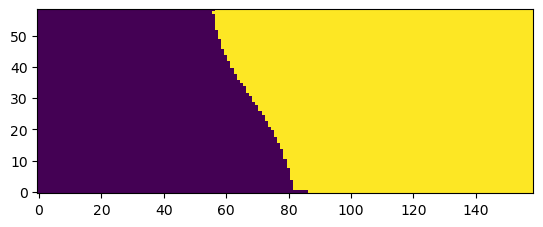

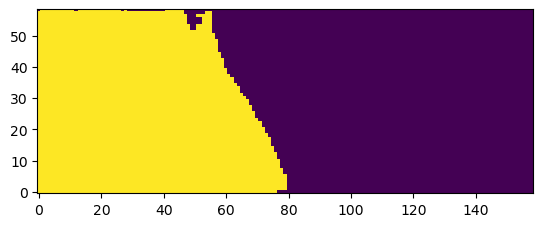

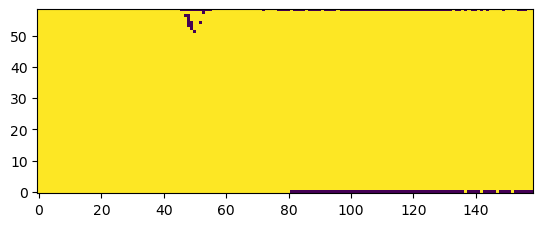

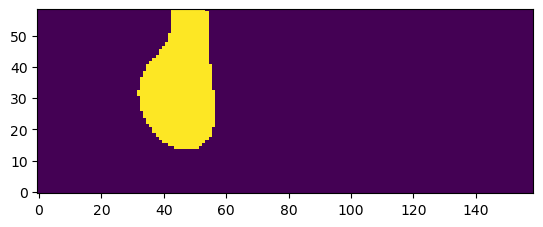

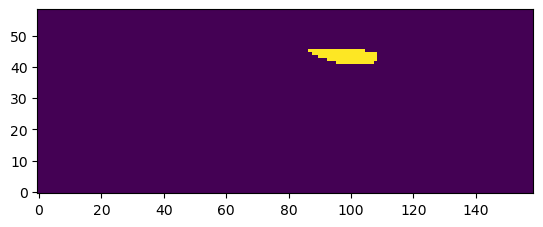

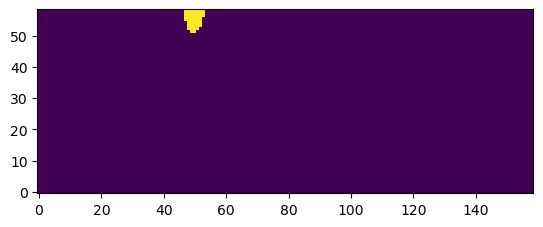

7


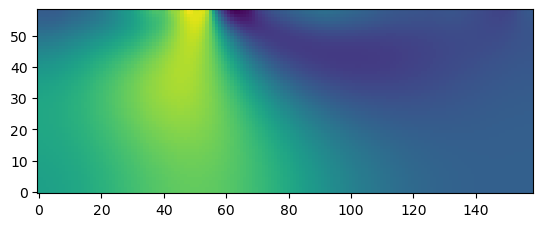

In [33]:
results = segmentor.masks
for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')

    plt.imshow(reshape.T)
    plt.gca().invert_yaxis()
    plt.show()
print(len(result))

flatten = dip_model
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T)
plt.gca().invert_yaxis()
plt.show()


  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




C:\Users\johnk\AppData\Local\Temp\ipykernel_22648\3234853524.py:55: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm = mesh.plotImage(model, ax=ax, pcolorOpts={'cmap':'viridis'})
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\discretize\utils\code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


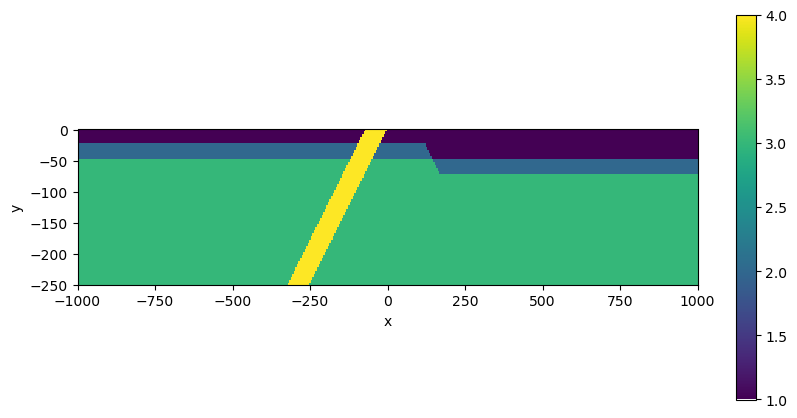

C:\Users\johnk\AppData\Local\Temp\ipykernel_22648\3234853524.py:79: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
C:\Users\johnk\AppData\Local\Temp\ipykernel_22648\3234853524.py:85: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm = meshCore.plotImage(



  TensorMesh: 9,381 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    159       -397.50        397.50      5.00      5.00    1.00
   y     59       -297.50         -2.50      5.00      5.00    1.00




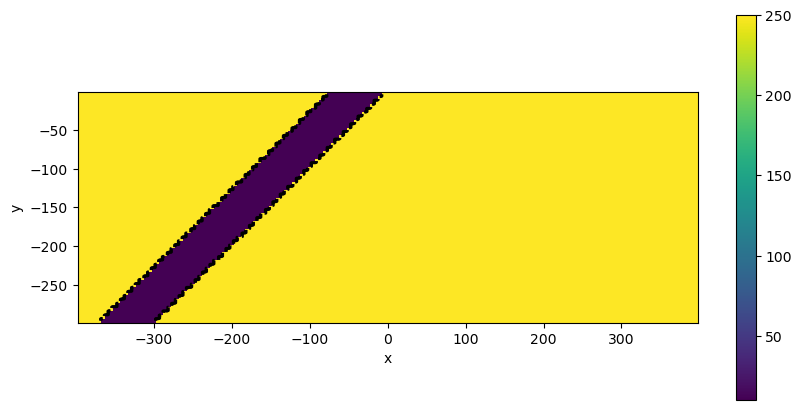

In [10]:
# -----------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift
domain = np.ones(mesh.nC, dtype='int64')
domain0 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],-1,100.)
domain[domain0] = 0

# Layered Earth
layered_model0 = 3 * np.ones(mesh.nC, dtype='int64')
layered_model0[mesh.gridCC[:,1]>-50] = 2
layered_model0[mesh.gridCC[:,1]>-25] = 1

layered_model1 = 3 * np.ones(mesh.nC, dtype='int64')
layered_model1[mesh.gridCC[:,1]>-75] = 2
layered_model1[mesh.gridCC[:,1]>-50] = 1

model = layered_model1
model[domain0] = layered_model0[domain0]

# Dike 45*
dike0 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 0)
dike1 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 75)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(1,1,figsize=(10,5))
mm = mesh.plotImage(model, ax=ax, pcolorOpts={'cmap':'viridis'})

plt.gca().set_xlim([-1000,1000])
plt.gca().set_ylim([-250,0])
plt.gca().set_aspect(2)
plt.colorbar(mm[0])

plt.show()

# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==1]= 250
res_true[model==2]= 250
res_true[model==3]= 250
res_true[model==4]= 10

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)
print(meshCore)

# plot
fig,ax = plt.subplots(1,1,figsize=(10,5))
mm = meshCore.plotImage(
    
    1/(cond_true)[actcore],
    ax=ax,
    pcolorOpts={'cmap':'viridis'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
plt.gca().set_aspect(1)
plt.colorbar(mm[0])
plt.show()

c:\users\johnk\documents\github\simpeg_jc\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:756: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
c:\users\johnk\documents\github\simpeg_jc\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:783: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


0.050000466041373835
74.97823878383728
0.052735370113818084
0.3001707785194677


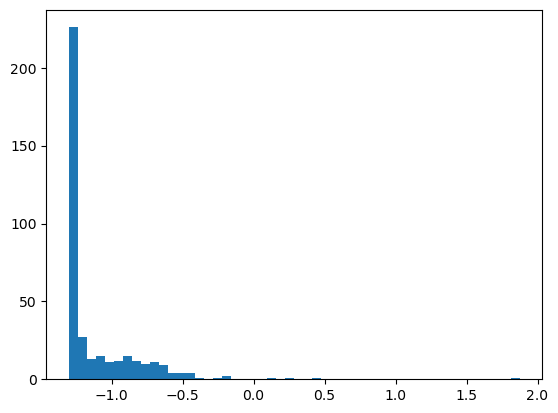

In [3]:
#np.linspace(25,250,10)

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=12,
        #d2flag="2.5D"
    
    )
    
    srclist +=(survey1.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.05
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=1e-4,
    force=True,
    add_noise=True,

)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
plt.hist(np.log10(relative_error_list), 50)
plt.show()



m0 = np.log(1/250) * np.ones(mapping.nP)

In [5]:
meshCore.nC

9381

In [6]:
# Setup the inversion proceedure
# Define a counter
# Data misfit
dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
dmis.W = 1 / dc_data.standard_deviation
# Regularization
regmap = maps.IdentityMap(nP=int(actcore.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=regmap,
    reference_model=m0
)
reg.alpha_s = 0.01
reg.alpha_x = 1
reg.alpha_y = 1
reg.alpha_z = 100

# Optimization object
opt = optimization.ProjectedGNCG(maxIter=3, lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=100, tolCG=1e-5)

opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg,  opt)
invProb.beta = 1e-2

# Inversion directives
Target = directives.TargetMisfit()
betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
# updateSensW = directives.UpdateSensitivityWeights(threshold=1e-6,everyIter=False)
# update_Jacobi = directives.UpdatePreconditioner()
inv = inversion.BaseInversion(invProb,  directiveList=[ # updateSensW, 
                                                       Target,
                                                       betaSched,
                                                    #    update_Jacobi,
                                                       ])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m0)
print('Inversion took {0} seconds'.format(time.time() - start))


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  1.00e-02  7.42e+05  0.00e+00  7.42e+05    9.86e+02      0              


KeyboardInterrupt: 

C:\Users\johnk\AppData\Local\Temp\ipykernel_28112\2630608758.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(mopt), ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\discretize\utils\code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


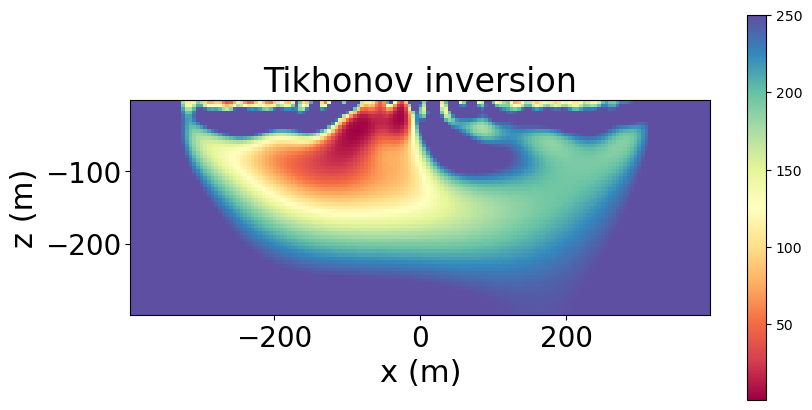

In [36]:
# Plot the recovered model
clim = [1, 250]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(1 / np.exp(mopt), ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
# ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)

In [6]:
n = 4
gmmref = GaussianMixtureSam(
    n_components=n, 
    mesh=meshCore,
    kneighbors=24,
    covariance_type='full',
    segmentation_model_checkpoint='/home/juan/Documents/git/jresearch/PGI/dcip/sam_vit_h_4b8939.pth'
)
gmmref.fit(mtrue[actcore].reshape(-1, 1))

# Manually setting the GMM parameters
## Order cluster by order of importance

# Set cluster 
# res_true[model==1]= 50
# res_true[model==2]= 250
# res_true[model==3]= 100
# res_true[model==4]= 10

gmmref.means_ = np.r_[-np.log(10.), -np.log(50.), -np.log(100.), -np.log(250.)][:,np.newaxis]

gmmref.covariances_ = np.array([[[0.001]],
                             [[0.001]],
                             [[0.001]],
                             [[0.001]]])
##Set clusters precision and Cholesky decomposition from variances
gmmref.compute_clusters_precisions()


Computing KDTree, it may take several minutes.
Computing neighbors, it may take several minutes.


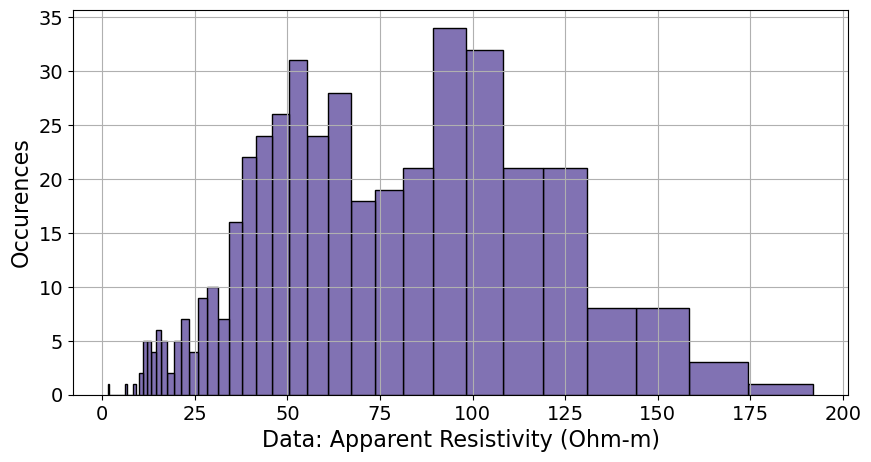

array([<Axes: xlabel='Physical property 0', ylabel='Probability Density values'>],
      dtype=object)

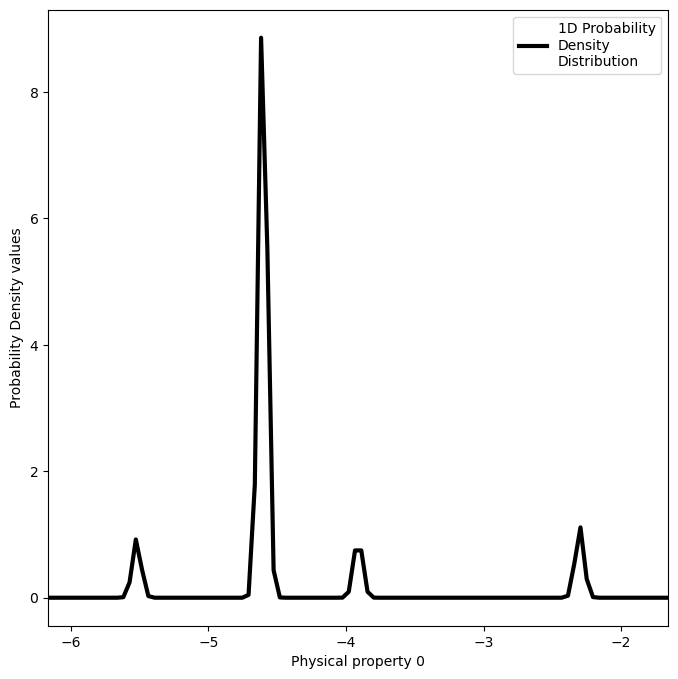

In [7]:
# Plot the histogram of the data
fig, ax = plt.subplots(1,1,figsize=(10,5))
hist, edges = np.histogram(-np.log(((dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs)))),bins=50, density=False)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",color='#8172B3');
# ax.plot((1./np.exp(-4.72760309)*np.ones(2)),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(115,30,'Starting half-space\nwhen no mean\npetrophysical information\nis available',fontsize=16)
# ax.plot(100.*np.ones(2),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(98,20,'True\nbackground\nmean',fontsize=16,ha='right')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")

ax.set_xlabel('Data: Apparent Resistivity (Ohm-m)',fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylabel('Occurences',fontsize=16)
# ax.set_xticks(np.r_[75,100,125,150])
plt.show()
# gmmref.weights_
gmmref.plot_pdf()
# testXplot = np.logspace(np.log(0.1), np.log(500), 1000,base=10)[:,np.newaxis]

# ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))) / 4,linewidth=3,label='True petrophysical\ndistribution',c='r',
#        path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])

In [ ]:
1 / np.exp(-2.5)

### Directives

In [8]:
from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)
# -----------------------------------------------------------------------

# creating directives and additional classes

#

#plot learned mref
class plot_mref(directives.InversionDirective):
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            self.invProb.reg.objfcts[0].mref, ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        utils.plot2Ddata(
            meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
            contourOpts={'alpha':0},
            #clim=[0,5],
            ax=ax[0],
            level=True,
            ncontour=2,
            levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
            method='nearest'
        )

        ax[2].hist(self.opt.xc, 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        plt.show()

# update the neighbors

class update_segmentation_neighbours(directives.InversionDirective):
    
    def initialize(self):
        self.count = 0
        # self.endIter()

        pgi_reg = self.reg.get_functions_of_type(PGIsmallness)
        if len(pgi_reg) != 1:
            raise UserWarning(
                "'PGI_UpdateParameters' requires one 'PGIsmallness' regularization "
                "in the objective function."
            )
        self.pgi_reg = pgi_reg[0]
    
    def endIter(self):

        print(f"iteration: {self.opt.iter}")
        if self.count > 15:

            self.pgi_reg.gmmref.segment(self.opt.xc)

            self.pgi_reg.gmm = self.pgi_reg.gmmref

            result = self.pgi_reg.gmm.masks
            fig, ax = plt.subplots(3,2, figsize=(10, 10))
            result[0].keys()
            # ax[0, 0].imshow(np.log(model.reshape(self.mesh.shape_cells, order='F')).T)
            ax[0, 0].invert_yaxis()
            ax[0, 0].set_title('PGI recovered model')

            # for i in range(4):
            ax[0, 1].imshow(result[1]['segmentation'].T)
            ax[0, 1].invert_yaxis()
            ax[0, 1].set_title('SAM segmentation item 1')
            if len(result) > 2:
                ax[1, 0].imshow(result[2]['segmentation'].T)
                ax[1, 0].invert_yaxis()
                ax[1, 0].set_title('SAM segmentation item 2')
                ax[1, 1].imshow(result[3]['segmentation'].T)
                ax[1, 1].invert_yaxis()
                ax[1, 1].set_title('SAM segmentation item 3')
                ax[2, 0].imshow(result[0]['segmentation'].T)
                ax[2, 0].invert_yaxis()
                ax[2, 0].set_title('SAM segmentation item 0')
                ax[2, 1].imshow(result[4]['segmentation'].T)
                ax[2, 1].invert_yaxis()
                ax[2, 1].set_title('SAM segmentation item 0')
            plt.tight_layout()
            plt.show()

        else:

            self.count += 1


class PGIUpdateParameters(directives.InversionDirective):
    """
    This directive is to be used with regularization from regularization.pgi.

    Custom PGI_UpdateParameters class that updates the reference model only
    after the data misfits targets have been achieved.

    It updates:
        - the reference model and weights in the smallness (L2-approximation of PGI)
        - the GMM as a MAP estimate between the prior and the current model
    For more details, please consult:
     - https://doi.org/10.1093/gji/ggz389
    """

    verbose = False  # print info.  about the GMM at each iteration
    update_rate = 1  # updates at each `update_rate` iterations
    update_gmm = False  # update the GMM
    zeta = (
        1e10  # confidence in the prior proportions; default: high value, keep GMM fixed
    )
    nu = (
        1e10  # confidence in the prior covariances; default: high value, keep GMM fixed
    )
    kappa = 1e10  # confidence in the prior means;default: high value, keep GMM fixed
    update_covariances = (
        True  # Average the covariances, If false: average the precisions
    )
    fixed_membership = None  # keep the membership of specific cells fixed
    keep_ref_fixed_in_Smooth = True  # keep mref fixed in the Smoothness
    update_reference_model = (
        False  # don't update reference model until data misfits targets are hit
    )

    def initialize(self):
        pgi_reg = self.reg.get_functions_of_type(PGIsmallness)
        if len(pgi_reg) != 1:
            raise UserWarning(
                "'PGI_UpdateParameters' requires one 'PGIsmallness' regularization "
                "in the objective function."
            )
        self.pgi_reg = pgi_reg[0]

    def endIter(self):
        if self.opt.iter > 0 and self.opt.iter % self.update_rate == 0:
            m = self.invProb.model
            modellist = self.pgi_reg.wiresmap * m
            model = np.c_[[a * b for a, b in zip(self.pgi_reg.maplist, modellist)]].T

            if self.update_gmm and isinstance(
                self.pgi_reg.gmmref, GaussianMixtureWithNonlinearRelationships
            ):
                clfupdate = GaussianMixtureWithNonlinearRelationshipsWithPrior(
                    gmmref=self.pgi_reg.gmmref,
                    zeta=self.zeta,
                    kappa=self.kappa,
                    nu=self.nu,
                    verbose=self.verbose,
                    prior_type="semi",
                    update_covariances=self.update_covariances,
                    max_iter=self.pgi_reg.gmm.max_iter,
                    n_init=self.pgi_reg.gmm.n_init,
                    reg_covar=self.pgi_reg.gmm.reg_covar,
                    weights_init=self.pgi_reg.gmm.weights_,
                    means_init=self.pgi_reg.gmm.means_,
                    precisions_init=self.pgi_reg.gmm.precisions_,
                    random_state=self.pgi_reg.gmm.random_state,
                    tol=self.pgi_reg.gmm.tol,
                    verbose_interval=self.pgi_reg.gmm.verbose_interval,
                    warm_start=self.pgi_reg.gmm.warm_start,
                    fixed_membership=self.fixed_membership,
                )
                clfupdate = clfupdate.fit(model)

            elif self.update_gmm and isinstance(
                self.pgi_reg.gmmref, WeightedGaussianMixture
            ):
                clfupdate = GaussianMixtureWithPrior(
                    gmmref=self.pgi_reg.gmmref,
                    zeta=self.zeta,
                    kappa=self.kappa,
                    nu=self.nu,
                    verbose=self.verbose,
                    prior_type="semi",
                    update_covariances=self.update_covariances,
                    max_iter=self.pgi_reg.gmm.max_iter,
                    n_init=self.pgi_reg.gmm.n_init,
                    reg_covar=self.pgi_reg.gmm.reg_covar,
                    weights_init=self.pgi_reg.gmm.weights_,
                    means_init=self.pgi_reg.gmm.means_,
                    precisions_init=self.pgi_reg.gmm.precisions_,
                    random_state=self.pgi_reg.gmm.random_state,
                    tol=self.pgi_reg.gmm.tol,
                    verbose_interval=self.pgi_reg.gmm.verbose_interval,
                    warm_start=self.pgi_reg.gmm.warm_start,
                    fixed_membership=self.fixed_membership,
                )
                clfupdate = clfupdate.fit(model)

            else:
                clfupdate = copy.deepcopy(self.pgi_reg.gmmref)

            self.pgi_reg.gmm = clfupdate
            membership = self.pgi_reg.gmm.predict(model)

            if self.fixed_membership is not None:
                membership[self.fixed_membership[:, 0]] = self.fixed_membership[:, 1]

            if getattr(self.fixed_membership, "shape", [0, 0])[0] < len(membership):
                self.pgi_reg._r_second_deriv = None

            # Start updating reference model after we hit the data misfit targets
            if self.data_misfits_achieved:
                self.update_reference_model = True

            # Update reference model after data misfits targets have been hit
            if self.update_reference_model:
                print("updating reference model")
                mref = mkvc(self.pgi_reg.gmm.means_[membership])
                self.pgi_reg.reference_model = mref

    @property
    def data_misfits_achieved(self):
        """Returns True if data misfits have been achieved"""
        return self.multi_target_misfits_directive.DM

    @property
    def directives(self):
        """List of all the directives in the :class:`SimPEG.inverison.BaseInversion``."""
        return self.inversion.directiveList.dList

    @property
    def multi_target_misfits_directive(self):
        """``MultiTargetMisfit`` directive in the :class:`SimPEG.inverison.BaseInversion``."""
        if not hasattr(self, "_mtm_directive"):
            # Obtain multi target misfits directive from the directive list
            multi_target_misfits_directive = [
                directive
                for directive in self.directives
                if isinstance(directive, directives.MultiTargetMisfits)
            ]
            if not multi_target_misfits_directive:
                raise UserWarning(
                    "No MultiTargetMisfits directive found in the current inversion. "
                    "A MultiTargetMisfits directive is needed by the "
                    "PGI_BetaAlphaSchedule directive."
                )
            (self._mtm_directive,) = multi_target_misfits_directive
        return self._mtm_directive


class SavePGIOutput(directives.InversionDirective):
    """
    Directive to save items of interest during the course of an inversion

    Inspired in custom class from:
    https://github.com/simpeg/transform-2020-simpeg
    """

    def __init__(self, path):
        """
        Initialize the directive

        Parameters
        ----------
        path : str or path-like object
        """
        super().__init__()
        # Convert path to Path if it's a str
        if type(path) == str:
            path = Path(path)
        # Create the parent dir if it doesn't exists
        if not path.parent.exists():
            os.makedirs(str(path.parent))
        # Warn the user if the file already exists
        if path.exists():
            if path.is_dir():
                raise ValueError(f"Path '{path}' is a directory and already exists.")
            warnings.warn(
                f"File '{path}' already exists. If you continue it will be overwritten",
                UserWarning,
            )
        self.path = path

    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results
        self._columns = (
            "iteration",
            "beta",
            "alpha_pgi",
            "alpha_smooth",
            "alpha_x",
            "alpha_y",
            "alpha_z",
            "phi_d",
            "phi_m",
            "phi_m_pgi",
            "phi_m_smooth_x",
            "phi_m_smooth_y",
            "phi_m_smooth_z",
            "phims",
        )
        self.inversion_results = {column: [] for column in self._columns}
        # create output file
        with open(self.path, "w") as f:
            f.write(f"# Output of inversion run on {datetime.now()}\n")
            f.write("# " + "\t".join(self._columns) + "\n")

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append
        the new values to our dictionary
        """

        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["beta"].append(self.invProb.beta)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["phi_m"].append(self.invProb.phi_m)

        # grab the components of the regularization and evaluate them here
        # the regularization has a list of objective functions
        # objfcts = [PGIsmallness, WeightedLeastSquares]
        # and the multipliers contain the alpha values
        # multipliers = [alpha_pgi, alpha_wls]
        pgi, weighted_least_squares = self.reg.objfcts[:]
        pgi_multiplier, wls_multiplier = self.reg.multipliers[:]
        self.inversion_results["alpha_pgi"].append(pgi_multiplier)
        self.inversion_results["alpha_smooth"].append(wls_multiplier)
        self.inversion_results["phi_m_pgi"].append(
            pgi(self.invProb.model) * pgi_multiplier
        )

        # WeightedLeastSquares has inside all type of regularizations in the
        # following order:
        #   smallness, x_smoothness, xx, y_smoothness, yy, z_smoothness, zz.
        # We just want the *_smoothness ones.
        x_smooth = weighted_least_squares.objfcts[1]
        x_smooth_multiplier = weighted_least_squares.multipliers[1]
        alpha_x = wls_multiplier * x_smooth_multiplier
        self.inversion_results["alpha_x"].append(alpha_x)
        self.inversion_results["phi_m_smooth_x"].append(
            x_smooth(self.invProb.model) * alpha_x
        )
        y_smooth = weighted_least_squares.objfcts[3]
        y_smooth_multiplier = weighted_least_squares.multipliers[3]
        alpha_y = wls_multiplier * y_smooth_multiplier
        self.inversion_results["alpha_y"].append(alpha_y)
        self.inversion_results["phi_m_smooth_y"].append(
            y_smooth(self.invProb.model) * alpha_y
        )
        z_smooth = weighted_least_squares.objfcts[5]
        z_smooth_multiplier = weighted_least_squares.multipliers[5]
        alpha_z = wls_multiplier * z_smooth_multiplier
        self.inversion_results["alpha_z"].append(alpha_z)
        self.inversion_results["phi_m_smooth_z"].append(
            z_smooth(self.invProb.model) * alpha_z
        )

        # Get phims
        phims = self._get_phims()
        self.inversion_results["phims"].append(phims)

        # append values to the output file
        values = [
            f"{self.inversion_results[column][-1]:.2e}"
            if column != "iteration"
            else f"{self.inversion_results[column][-1]:d}"
            for column in self._columns
        ]
        with open(self.path, "a") as f:
            f.write("\t".join(values) + "\n")

    def _get_phims(self):
        """
        Return the value of `phims` at the end of the current iteration

        A.k.a. smallness misfit or clusterization misfit
        """
        # Get list of all directives in the inversion
        directives_list = self.inversion.directiveList.dList
        # Get the MultiTargetMisfits
        multi_target_misfit_directive = [
            directive
            for directive in directives_list
            if isinstance(directive, MultiTargetMisfits)
        ]
        if not multi_target_misfit_directive:
            raise ValueError("No MultiTargetMisfits directive found in the inversion.")
        if len(multi_target_misfit_directive) > 1:
            raise ValueError(
                "Multiple MultiTargetMisfits directives found in the inversion."
            )
        multi_target_misfit_directive = multi_target_misfit_directive[0]
        # Compute phims
        return multi_target_misfit_directive.phims()

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2519: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2526: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  warnings.warn(



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
<class 'SimPEG.regularization.pgi.PGIsmallness'>
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  1.34e+05  0.00e+00  1.34e+05    1.93e+04      0              
iteration: 1
geophys. misfits: 25755.4 (target 215.5 [False]) | smallness misfit: 72531.0 (target: 4690.5 [False])
Beta cooling evaluation: progress: [25755.4]; minimum progress targets: [120951.8]


/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:642: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)


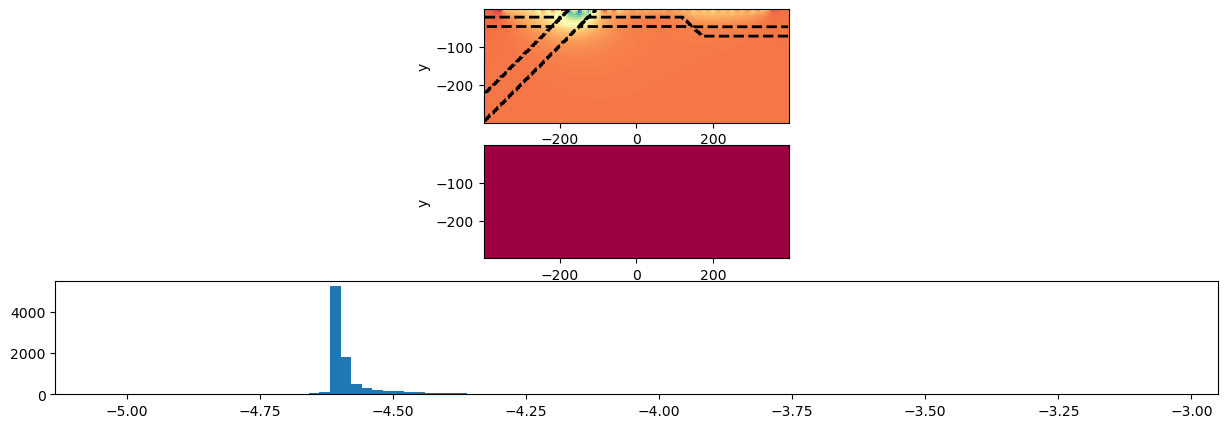

   1  1.00e-02  2.58e+04  1.81e+06  4.39e+04    1.80e+03      0              
iteration: 2
in predict!
geophys. misfits: 19150.3 (target 215.5 [False]) | smallness misfit: 82313.9 (target: 4690.5 [False])
Beta cooling evaluation: progress: [19150.3]; minimum progress targets: [23179.9]


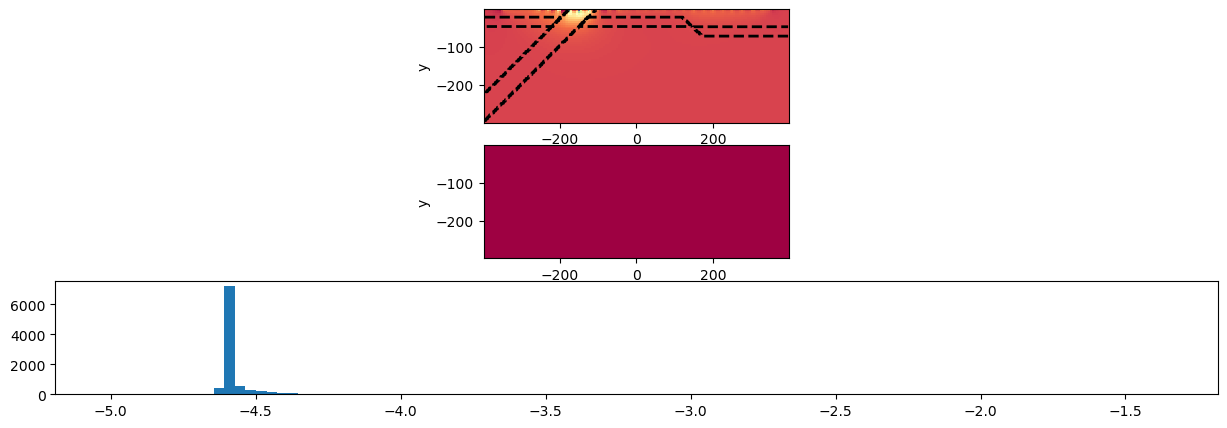

   2  1.00e-02  1.92e+04  2.06e+06  3.97e+04    1.30e+03      0   Skip BFGS  
iteration: 3
geophys. misfits: 10885.2 (target 215.5 [False]) | smallness misfit: 78779.4 (target: 4690.5 [False])
Beta cooling evaluation: progress: [10885.2]; minimum progress targets: [17235.2]


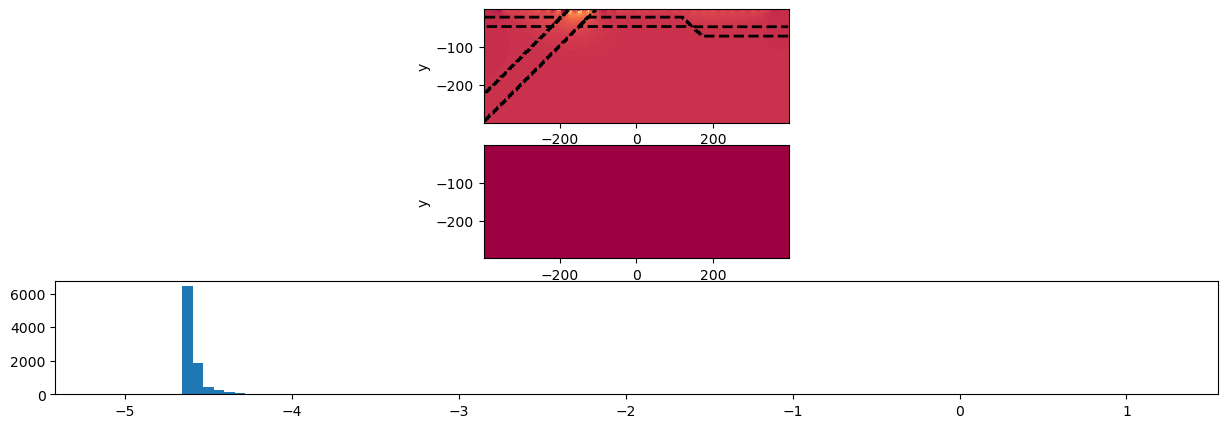

   3  1.00e-02  1.09e+04  1.97e+06  3.06e+04    2.02e+03      0              
iteration: 4
in predict!
geophys. misfits: 8860.6 (target 215.5 [False]) | smallness misfit: 62085.6 (target: 4690.5 [False])
Beta cooling evaluation: progress: [8860.6]; minimum progress targets: [9796.7]


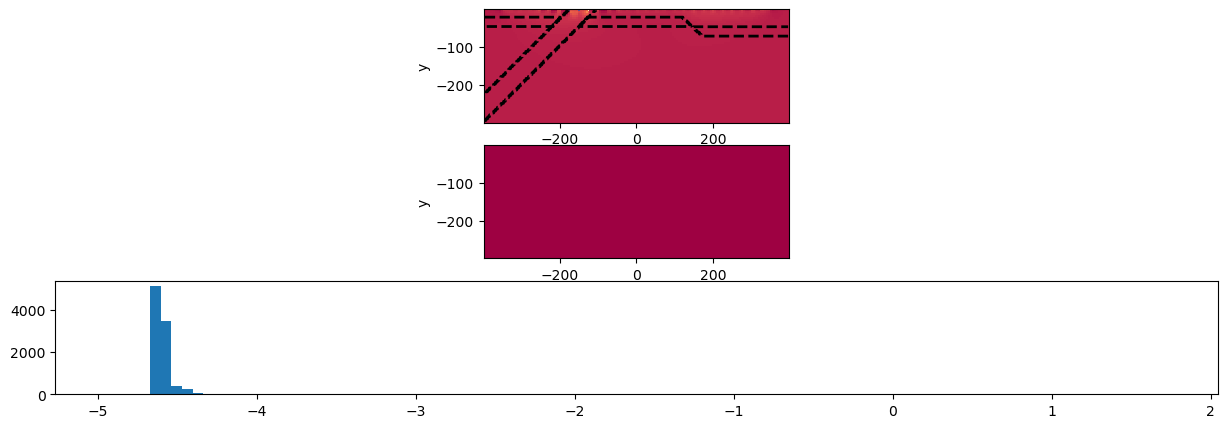

   4  1.00e-02  8.86e+03  1.56e+06  2.44e+04    5.96e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.1860e+03 <= tolF*(1+|f0|) = 1.3439e+04
1 : |xc-x_last| = 5.6022e+00 <= tolX*(1+|x0|) = 4.4704e+01
0 : |proj(x-g)-x|    = 5.9595e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 5.9595e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       4    <= iter          =      4
------------------------- DONE! -------------------------


In [10]:
dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))
reg_mean = regularization.PGI(
    gmm=gmmref,
    gmmref=gmmref, 
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    reference_model=m0,
    indActive=actcore
)

# Weighting
reg_mean.alpha_s = 1
reg_mean.alpha_x = 100
reg_mean.alpha_y = 100
# reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=4, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

# Inversion directives
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True, coolingFactor=5.,
    warmingFactor=1., tolerance=0.05,
    progress=0.1
)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
petrodir = PGIUpdateParameters(
    update_covariances=True,
    kappa = 1e8,
    nu = 1e8,
    update_rate = 2,
    update_reference_model=False
    )
update_sam = update_segmentation_neighbours()
plot_iter_mref = plot_mref()
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e-2
inv = inversion.BaseInversion(invProb,
                              directiveList=[
                                            #  updateSensW,
                                             update_sam,
                                             petrodir,
                                             targets, betaIt,
                                            #  MrefInSmooth,
                                             plot_iter_mref,
                                            #  update_Jacobi,
                                             ])

# Run!
mcluster = inv.run(m0)

/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/utils/code_utils.py:264: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/discretize/mixins/mpl_mod.py:305: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  warnings.warn(


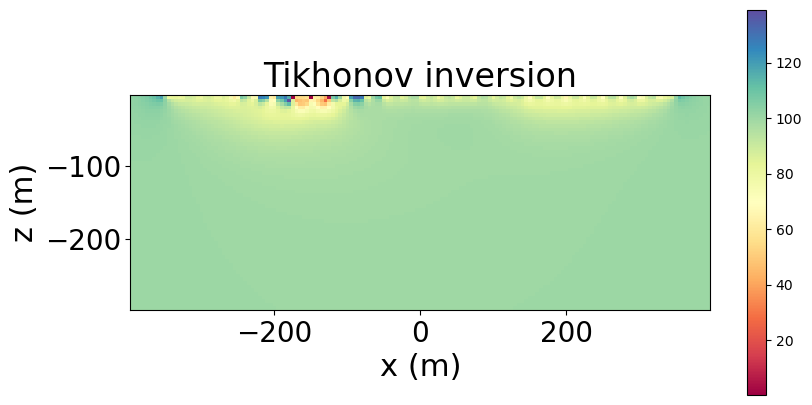

In [11]:
# Plot the recovered model
clim = [1, 500]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(1 / np.exp(mcluster), ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
# ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)